# Steady State PDF of Double-Welled Overdamped Langevin Equation

In [2]:
using JLD
using DifferentialEquations
using Plots
pyplot()


Plots.PyPlotBackend()

## Emperical PDF
From previously computed data, form parameters listed below, I compute the emperical pdf of the "double-welled" overdamped Langevin equation.

First I load the histogram and then conect the dots quadratically.

In [2]:
data_dict = load("data\\full_model_run_pdf.jld")
pdf_N = data_dict["dat_pdf_N"]
b_mpts = data_dict["dat_b_mpts"]

function p(z)
    i = argmin(abs.(b_mpts .- z))
    if (i == 1) | (i == length(b_mpts))
        x = [1; 2; 3]
        y = zeros(3)
    else
        x = b_mpts[i-1:i+1]
        y = pdf_N[i-1:i+1]
    end
    a = [x.^2 x ones(3)] \ y
    P = a[1]*z^2 + a[2]*z + a[3]
end

p (generic function with 1 method)

## Numerical approximation of exact PDF from Fokker-Plank equation

Here we have Langevin equation
$$\frac{dx}{dt} = -u'(x) +\sigma v_t$$
where 
\begin{align}
&u(x) = \frac{1}{4}(x^2 - 1)^2, \\
&v_t \sim N(0,1)\quad \text{(i.i.d.), and} \\
&\sigma = .35.
\end{align}

The Fokker-Plank equation for the probability distribution $f(x,t)$ then is

$$\frac{\partial f}{\partial t} = \frac{\partial }{\partial x}U'(x)f + kT\frac{\partial^2 }{\partial^2 x}f$$
We seek the steady state distribution. So, $\frac{\partial f}{\partial t} = 0$.
This gives the homogenous differential equation 
$$0 = U''f + U'f' + kTf'' = (3x^2 - 1)f(x) + (x^3 - x)f'(x) + kTf''(x)$$
since here $kT = \sigma^2/2$.  

We then solve this unmerically using `DifferentialEquations.jl`.

In [3]:
σ = data_dict["sigma"][1]

function RHS!(dU,U,μ,t)
    dU[1] = U[2]
    dU[2] = -1/μ*(3t^2 - 1)*U[1] - 1/μ*(t^3 -t)*U[2]
end

U0 = [p(0);0] # Here we cheat and use the emperical value at 0
tspan = (0.0,2.0)
μ = σ^2/2
prob = ODEProblem(RHS!,U0,tspan,μ)
sol = solve(prob)

p_num(x) = x>=0 ? sol(x)[1] : sol(-x)[1]

p_num (generic function with 1 method)

## Try this

In [7]:
p_test(x) = exp(-(x^2-1)^2/μ)

p_test (generic function with 1 method)

## Compare solutions

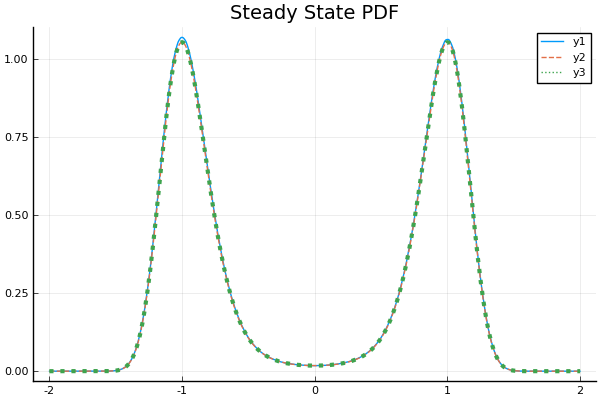

In [8]:
x = -2:0.01:2
plot(x,p.(x),lable = "Emperical pdf")
plot!(x,p_num.(x),
    line = :dash,
    lable = "Exact pdf",
    title = "Steady State PDF")
plot!(x,p_num.(x),
    line = (3,:dot),
    lable = "Exact pdf")
